# Windfinder Prediction of Surfing Conditions
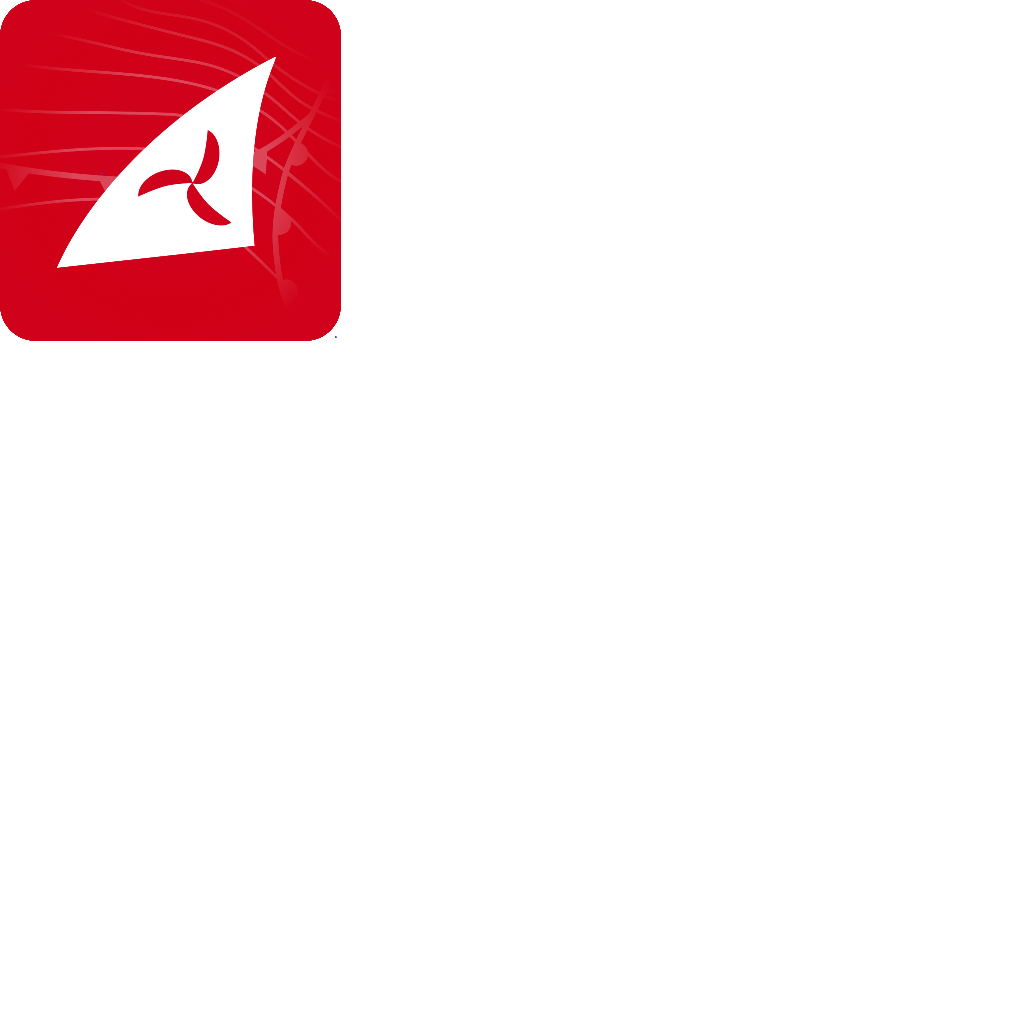

## Participants:
1. Irena Kampa
2. Kai Paulsen
3. Prosper Kwabena Adjei
4. John Kimani
5. Jannik Knopp

### Waterkant Hackathon 2021


In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental import preprocessing

# set path to the windfinder_data folder
# change this if you have a different setting in your environment
path = os.path.join(os.getcwd(), "data_windfinder")
spots = pd.read_csv(os.path.join(os.getcwd(), "Spot-Descriptions.csv"))

In [2]:
######################### Methods #####################################

# reads the data from spotID and year
# This does also correct the missing column label in the pageview data
def getDataFromID(spotID, year):
    pathToData = os.path.join(os.getcwd(), "data_windfinder")
    filenamePageviews = "pageviews_" + spotID + "_" + str(year) + ".csv"
    filenameWeatherData = filenamePageviews.replace("pageviews", "weatherdata")
    pageviews = pd.read_csv(os.path.join(pathToData, filenamePageviews), sep=";")
    weatherdata = pd.read_csv(os.path.join(pathToData, filenameWeatherData), sep=";")
    col1 = pageviews.columns
    pageviews.columns = ["Date", "Click Count"]
    # re-insert the line that was the colum title before
    first_line = pd.DataFrame({'Date': col1[0], 'Click Count': col1[1]}, index=[0])
    # concatenate two dataframe
    pageviews_Complete = pd.concat([first_line, pageviews.iloc[:]]).reset_index(drop=True)

    return pageviews_Complete, weatherdata


# reads the data and merges it together
# also does some pre processing with the date format
# this has to be done before merging due to different date formats used
def retrieveAndMergeData(spotID, year):    
    pv, wd = getDataFromID(spotID, year)
    date = pd.to_datetime(wd["date/time (UTC)"][3])
    wd["Date"] = pd.to_datetime(wd["date/time (UTC)"])
    wd['date/time (UTC)'] = pd.to_datetime(wd["date/time (UTC)"])
    wd['Date'] = wd['date/time (UTC)'].dt.date
    wd['Day_of_week'] = wd['date/time (UTC)'].dt.weekday
    wd['Month'] = wd['date/time (UTC)'].dt.month
    wd['Hour'] = wd['date/time (UTC)'].dt.hour
    # TODO add min max features

    # remove time before 6 am and past 22pm 
    wd.drop(wd[wd["Hour"] < 6.0].index, inplace=True)
    wd.drop(wd[wd["Hour"] > 21.0].index, inplace=True)
    wd = wd.drop(columns="Hour")
    
    # group data by day and compute the mean for this day
    wheater_data_by_date = wd.groupby(['Date']).mean()
    
    # change date format so it fits to the format in wheather data
    pv["Date"] = pd.to_datetime(pv["Date"], format="%Y%m%d").dt.date

    # merge both dataframes on the date column
    concat_data = pd.merge(wheater_data_by_date, pv, on=["Date"])
    return concat_data


def preprocessDataframe(dataframe):
    # drop all nan values
    dataframe = dataframe.dropna()
    # drop not usable column Date
    dataframe = dataframe.drop(columns="Date")
    dataframe["Click Count"] = pd.to_numeric(dataframe["Click Count"], downcast='float')
    # dataframe.drop(dataframe[dataframe["Click Count"] > 3000.0].index, inplace=True)
    return dataframe



def getCompleteDataForSpot(spots):
    datalist = []
    years =  ["2016", "2017", "2018", "2019"]
    # get the data for every year and add it to a list
    for year in years:
        datalist.append(retrieveAndMergeData(spots["ID"][1], year))
    dataframe = datalist[0]
    # merge all files together in one dataframe
    dataframe = dataframe.append([datalist[1], datalist[2], datalist[3]])

    dataframe = preprocessDataframe(dataframe)
    return dataframe


def createBestModelOneYear(input_shape, dataframe):
    tf.keras.backend.set_floatx('float64')
    normalizer = preprocessing.Normalization(input_shape=[input_shape])
    normalizer.adapt(np.array(dataframe))
    # creation of the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        normalizer,
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(16, activation="relu"),
        # last layer needs to have linear activation function because we solve a regression problem
        tf.keras.layers.Dense(1, activation="linear")
    ])
    # compile model
    model.compile(optimizer="adam", loss='mean_absolute_error', metrics=["mean_squared_error"])
    return model


def createCategoricalVariables(dataframe):
    dataframe = pd.get_dummies(dataframe, columns=["Month", "Day_of_week"])
    return dataframe

def shuffleAndSplitData(dataframe): 
    shuffled_data = shuffle(dataframe)

    Y = shuffled_data.pop("Click Count").to_frame()
    X = shuffled_data

    X_train, X_Test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    return X_train, X_Test, y_train, y_test


def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 200])
    plt.xlabel('Epoch')
    plt.ylabel('Error [Clicks]')
    plt.legend()
    plt.grid(True)
    
    
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss') < 10.0):
            print("Loss below 10. Training cancelled")
            self.model.stop_training = True

In [3]:
data_2016 = preprocessDataframe(retrieveAndMergeData(spots["ID"][1], 2016))
data_all_years = getCompleteDataForSpot(spots)
print(spots["ID"][1])

10028


# Data Visualization
In the following section the data from one year and from all years are visualized to interpret them better
1. The data of 2016
2. The distribution of the clicks over the time of 4 years
3. The data of all years

In [4]:
data_2016.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
wind speed [kts],346.0,12.098313,5.216617,3.375000,8.125000,11.093750,15.554228,31.875000
wind direction [degrees],346.0,200.282168,78.398181,24.375000,144.062500,219.375000,259.843750,324.666667
wind gust [kts],346.0,19.351908,7.548486,5.615385,13.500000,18.679487,23.528846,47.000000
air temperature [°C],346.0,11.103592,6.517396,-4.375000,5.889583,10.000000,17.234375,25.812500
Day_of_week,346.0,3.008671,1.997806,0.000000,1.000000,3.000000,5.000000,6.000000
Month,346.0,6.797688,3.311744,1.000000,4.000000,7.000000,10.000000,12.000000
Click Count,346.0,742.248535,392.573608,174.000000,407.000000,654.500000,993.250000,1814.000000


In [5]:
data_all_years.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
wind speed [kts],1433.0,12.645991,5.459072,3.062500,8.500000,11.500000,15.933333,36.0000
wind direction [degrees],1433.0,206.178815,76.526812,24.375000,148.125000,221.333333,265.000000,346.8750
wind gust [kts],1433.0,20.385477,7.968880,5.615385,14.333333,19.333333,25.153846,56.7000
air temperature [°C],1433.0,10.934372,6.645087,-6.937500,5.625000,10.333333,16.687500,28.9375
Day_of_week,1433.0,2.993022,1.999639,0.000000,1.000000,3.000000,5.000000,6.0000
Month,1433.0,6.592463,3.422730,1.000000,4.000000,7.000000,10.000000,12.0000
Click Count,1433.0,700.581970,438.858398,104.000000,347.000000,594.000000,972.000000,4003.0000


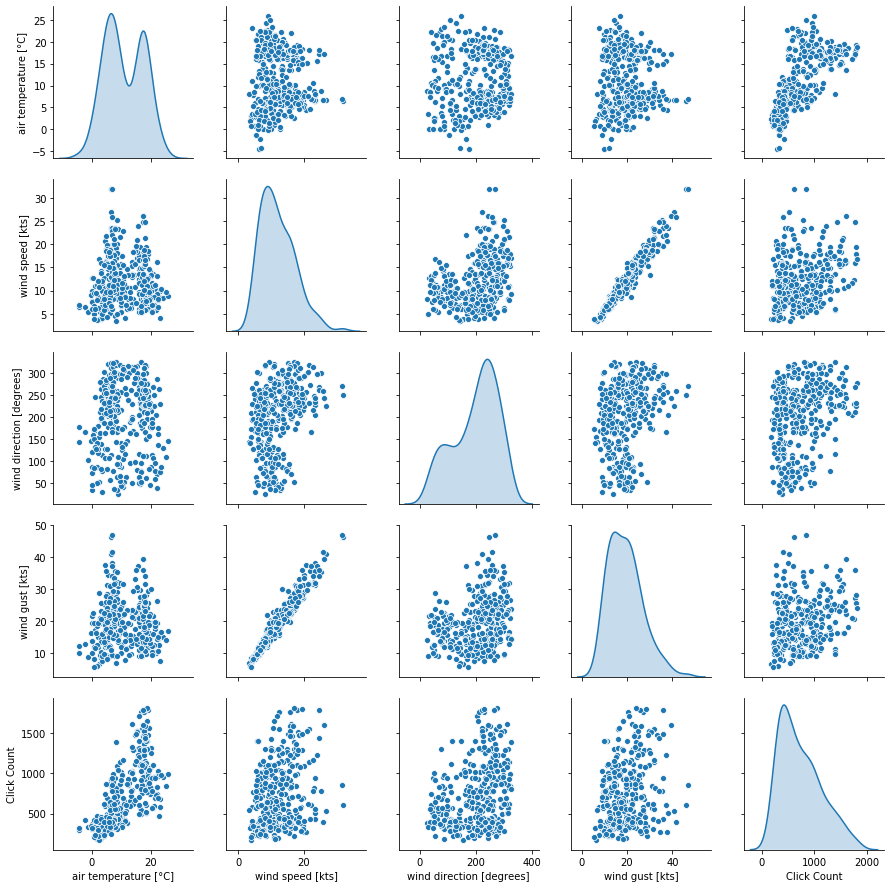

In [6]:
sns.pairplot(data_2016[['air temperature [°C]', 'wind speed [kts]', 'wind direction [degrees]', 'wind gust [kts]','Click Count']], diag_kind='kde')

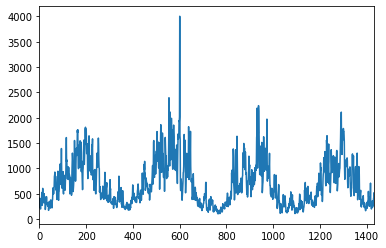

In [7]:
data_all_years['Click Count'].reset_index(drop=True).plot()

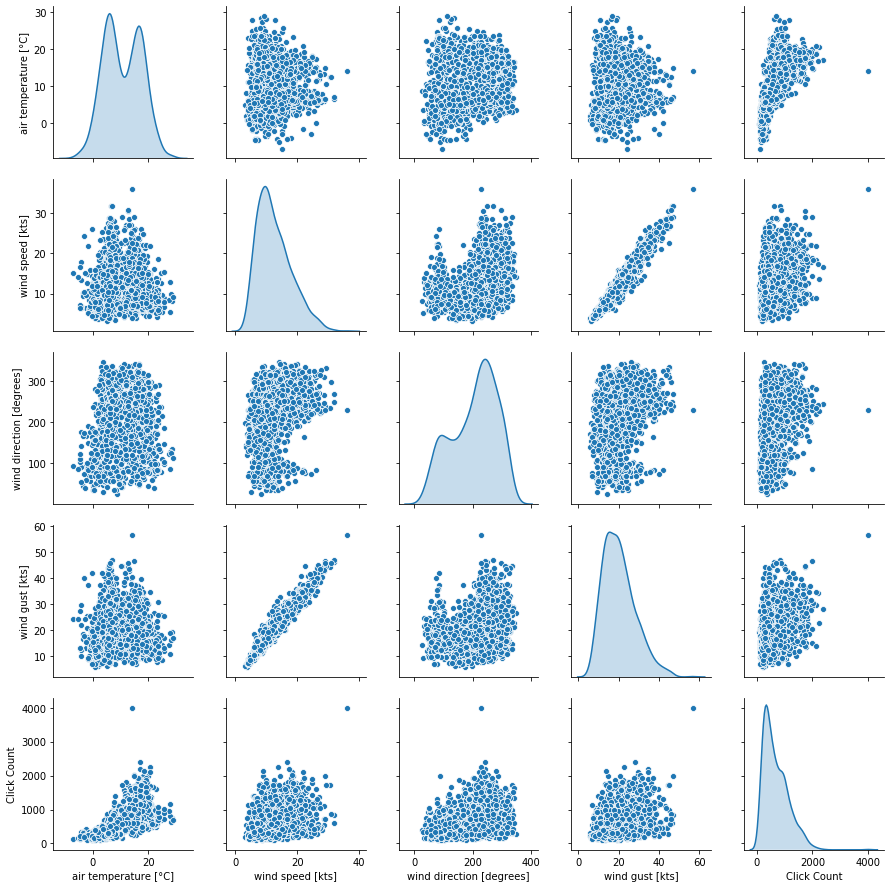

In [8]:
sns.pairplot(data_all_years[['air temperature [°C]', 'wind speed [kts]', 'wind direction [degrees]', 'wind gust [kts]','Click Count']], diag_kind='kde')

# Feature Engineering
In this section the modification of the features that improved our model very well are explained
1. Transform the day of the week and the month to a categorical variable
2. Transforming wind speed and direction to a vector
3. Mean data for a day
4. Excluded data from the night
5. Deleted outliers

Text(0, 0.5, 'Wind Speed')

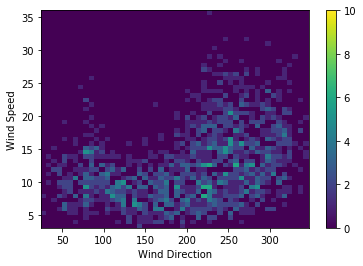

In [9]:
plt.hist2d(data_all_years['wind direction [degrees]'], data_all_years['wind speed [kts]'], bins=(50, 50), vmax=10)
plt.colorbar()
plt.xlabel('Wind Direction')
plt.ylabel('Wind Speed')

In [10]:
# Transform wind speed and direction into a wind vector
wind_speed = data_all_years['wind speed [kts]']
wind_dir_deg = data_all_years['wind direction [degrees]']

wind_dir_rad = wind_dir_deg * np.pi / 180

data_all_years["Wx"] = wind_speed * np.cos(wind_dir_rad)
data_all_years["Wy"] = wind_speed * np.sin(wind_dir_rad)

# transformation for 2016 data
wind_speed = data_2016['wind speed [kts]']
wind_dir_deg = data_2016['wind direction [degrees]']

wind_dir_rad = wind_dir_deg * np.pi / 180

data_2016["Wx"] = wind_speed * np.cos(wind_dir_rad)
data_2016["Wy"] = wind_speed * np.sin(wind_dir_rad)

Text(0, 0.5, 'Wy')

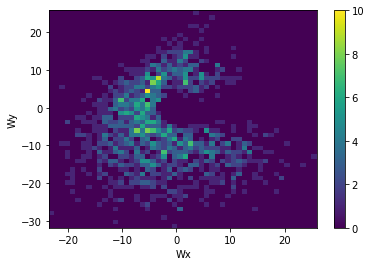

In [11]:
plt.hist2d(data_all_years['Wx'], data_all_years['Wy'], bins=(50, 50), vmax = 10)
plt.colorbar()
plt.xlabel('Wx')
plt.ylabel('Wy')

In [12]:
# drop data that had no effect on the result or is now duplicated
data_all_years = data_all_years.drop(columns = "wind speed [kts]")
data_all_years = data_all_years.drop(columns = "wind gust [kts]")
data_all_years = data_all_years.drop(columns = "wind direction [degrees]")

data_2016 = data_2016.drop(columns = "wind speed [kts]")
data_2016 = data_2016.drop(columns = "wind gust [kts]")
data_2016 = data_2016.drop(columns = "wind direction [degrees]")

### Things that did not work very well
1. Dropping any data that is now still in the model: 
    1. Month
    2. Weekday
    3. Windvektor (x,y)
    4. Air temperature
    5. (Year)
2. Categorizing the days of a week into Monday- Thursday and Friday, Saturday, Sunday as 4 classes
3. Grouping the months in seasons (unfortunally we did not have time to try this out)

# Models
We have used different models for two cases. The first case is the precdiction for one year and the second case including all data of all 4 years.

|  Method        | Used                |
| -------------- | ------------------- |
| Normalization  | Yes                 |
| Data Shuffling | Yes                 |
| Dropout        | 0.0                 |
| Loss-Function  | mean_absolute_error |
| Optimizer      | Adam                |
| Learning rate  | 0.001               |

### Model for one Year (2016)
Because different years have really different distribution of wheater data we tried out how well a model can work on one year in comparisson to a model that learns all years.

| Layer       | Number of Neurons | Activation Function |
| ----------- | ----------------- | ------------------- |
| 1      | 256             | ReLu |
| 2   | 128              | ReLu |
| 3      | 64             | ReLu |
| 4   | 32              | ReLu |
| 5      | 16             | ReLu |
| 6   | 1              | Linear |

For this model we also used early stopping below a validation loss of 10

In [13]:
data_2016 = createCategoricalVariables(data_2016)
X_train, X_Test, y_train, y_test = shuffleAndSplitData(data_2016)
data_2016.pop("Click Count")

18     236.0
19     417.0
20     295.0
21     322.0
22     202.0
       ...  
359    613.0
360    338.0
361    436.0
362    395.0
363    402.0
Name: Click Count, Length: 346, dtype: float32

In [ ]:
model = createBestModelOneYear(data_2016.shape[1], data_2016)
#earlyStoppingCallback = EarlyStoppingCallback()
history = model.fit(X_train, y_train, epochs=1000, validation_split=0.1,verbose = 1)

Epoch 1/1000
8/8 [==============================] - 0s 27ms/step - loss: 760.6828 - mean_squared_error: 738811.2248 - val_loss: 805.9297 - val_mean_squared_error: 801339.0121
Epoch 2/1000
8/8 [==============================] - 0s 5ms/step - loss: 758.5928 - mean_squared_error: 735575.7033 - val_loss: 802.3324 - val_mean_squared_error: 795534.5985
Epoch 3/1000
8/8 [==============================] - 0s 4ms/step - loss: 752.9351 - mean_squared_error: 727290.4417 - val_loss: 792.9023 - val_mean_squared_error: 780355.4134
Epoch 4/1000
8/8 [==============================] - 0s 4ms/step - loss: 738.4682 - mean_squared_error: 705422.7372 - val_loss: 769.7487 - val_mean_squared_error: 743717.5465
Epoch 5/1000
8/8 [==============================] - 0s 4ms/step - loss: 704.2142 - mean_squared_error: 655080.5362 - val_loss: 717.1381 - val_mean_squared_error: 664492.7001
Epoch 6/1000
8/8 [==============================] - 0s 4ms/step - loss: 628.2821 - mean_squared_error: 552052.8032 - val_loss: 60

8/8 [==============================] - 0s 5ms/step - loss: 82.0364 - mean_squared_error: 20258.4057 - val_loss: 171.3736 - val_mean_squared_error: 68719.4923
Epoch 49/1000
8/8 [==============================] - 0s 4ms/step - loss: 80.5287 - mean_squared_error: 19868.1281 - val_loss: 171.2351 - val_mean_squared_error: 69226.9677
Epoch 50/1000
8/8 [==============================] - 0s 4ms/step - loss: 80.0346 - mean_squared_error: 19978.7378 - val_loss: 173.0018 - val_mean_squared_error: 69518.3079
Epoch 51/1000
8/8 [==============================] - 0s 4ms/step - loss: 79.3376 - mean_squared_error: 19711.7484 - val_loss: 173.9036 - val_mean_squared_error: 70780.6889
Epoch 52/1000
8/8 [==============================] - 0s 4ms/step - loss: 79.6804 - mean_squared_error: 19561.5162 - val_loss: 172.6390 - val_mean_squared_error: 69004.1396
Epoch 53/1000
8/8 [==============================] - 0s 4ms/step - loss: 78.3428 - mean_squared_error: 18988.2591 - val_loss: 175.1238 - val_mean_squared_

Epoch 96/1000
8/8 [==============================] - 0s 5ms/step - loss: 62.3625 - mean_squared_error: 14939.9428 - val_loss: 195.0147 - val_mean_squared_error: 80279.0798
Epoch 97/1000
8/8 [==============================] - 0s 4ms/step - loss: 63.0443 - mean_squared_error: 14813.4361 - val_loss: 194.4968 - val_mean_squared_error: 79621.9010
Epoch 98/1000
8/8 [==============================] - 0s 4ms/step - loss: 63.6034 - mean_squared_error: 15069.4710 - val_loss: 194.2748 - val_mean_squared_error: 77305.1496
Epoch 99/1000
8/8 [==============================] - 0s 4ms/step - loss: 62.9238 - mean_squared_error: 15017.0518 - val_loss: 195.9371 - val_mean_squared_error: 78707.5939
Epoch 100/1000
8/8 [==============================] - 0s 4ms/step - loss: 61.6496 - mean_squared_error: 14931.2077 - val_loss: 191.1930 - val_mean_squared_error: 76800.4295
Epoch 101/1000
8/8 [==============================] - 0s 4ms/step - loss: 60.8372 - mean_squared_error: 14525.9698 - val_loss: 194.6162 - v

8/8 [==============================] - 0s 4ms/step - loss: 54.3777 - mean_squared_error: 12092.5254 - val_loss: 211.0773 - val_mean_squared_error: 86587.9964
Epoch 144/1000
8/8 [==============================] - 0s 5ms/step - loss: 55.3332 - mean_squared_error: 12332.4613 - val_loss: 208.4904 - val_mean_squared_error: 83002.3929
Epoch 145/1000
8/8 [==============================] - 0s 4ms/step - loss: 52.1332 - mean_squared_error: 11749.4317 - val_loss: 205.8688 - val_mean_squared_error: 81476.6927
Epoch 146/1000
8/8 [==============================] - 0s 4ms/step - loss: 52.1806 - mean_squared_error: 12372.5849 - val_loss: 210.1105 - val_mean_squared_error: 85508.6893
Epoch 147/1000
8/8 [==============================] - 0s 4ms/step - loss: 51.3751 - mean_squared_error: 11815.9445 - val_loss: 211.7458 - val_mean_squared_error: 87058.6609
Epoch 148/1000
8/8 [==============================] - 0s 4ms/step - loss: 54.7211 - mean_squared_error: 12018.8586 - val_loss: 209.9497 - val_mean_squ

8/8 [==============================] - 0s 4ms/step - loss: 44.5886 - mean_squared_error: 9824.7167 - val_loss: 218.0405 - val_mean_squared_error: 88791.6332
Epoch 191/1000
8/8 [==============================] - 0s 4ms/step - loss: 45.6581 - mean_squared_error: 9735.5049 - val_loss: 215.7362 - val_mean_squared_error: 89269.0126
Epoch 192/1000
8/8 [==============================] - 0s 5ms/step - loss: 45.2440 - mean_squared_error: 9604.5274 - val_loss: 221.6732 - val_mean_squared_error: 90411.6322
Epoch 193/1000
8/8 [==============================] - 0s 4ms/step - loss: 45.9291 - mean_squared_error: 9721.8249 - val_loss: 217.4285 - val_mean_squared_error: 88758.8149
Epoch 194/1000
8/8 [==============================] - 0s 4ms/step - loss: 44.8057 - mean_squared_error: 9858.6529 - val_loss: 217.8848 - val_mean_squared_error: 89675.9707
Epoch 195/1000
8/8 [==============================] - 0s 4ms/step - loss: 41.6935 - mean_squared_error: 9445.5989 - val_loss: 216.4835 - val_mean_squared_e

Epoch 238/1000
8/8 [==============================] - 0s 4ms/step - loss: 39.9011 - mean_squared_error: 7806.4713 - val_loss: 228.6218 - val_mean_squared_error: 93805.0845
Epoch 239/1000
8/8 [==============================] - 0s 4ms/step - loss: 40.4098 - mean_squared_error: 8204.9747 - val_loss: 221.7402 - val_mean_squared_error: 92333.9375
Epoch 240/1000
8/8 [==============================] - 0s 5ms/step - loss: 40.2542 - mean_squared_error: 7795.0694 - val_loss: 223.9282 - val_mean_squared_error: 93518.6132
Epoch 241/1000
8/8 [==============================] - 0s 4ms/step - loss: 40.1513 - mean_squared_error: 7926.8438 - val_loss: 225.6223 - val_mean_squared_error: 92920.4077
Epoch 242/1000
8/8 [==============================] - 0s 4ms/step - loss: 40.5885 - mean_squared_error: 7907.6563 - val_loss: 221.0016 - val_mean_squared_error: 91826.6573
Epoch 243/1000
8/8 [==============================] - 0s 4ms/step - loss: 41.4627 - mean_squared_error: 8020.9769 - val_loss: 223.7172 - val

8/8 [==============================] - 0s 4ms/step - loss: 34.5602 - mean_squared_error: 6318.2168 - val_loss: 225.9404 - val_mean_squared_error: 93970.2992
Epoch 286/1000
8/8 [==============================] - 0s 4ms/step - loss: 34.7428 - mean_squared_error: 6265.4749 - val_loss: 224.5686 - val_mean_squared_error: 94319.9502
Epoch 287/1000
8/8 [==============================] - 0s 4ms/step - loss: 35.7043 - mean_squared_error: 6223.1045 - val_loss: 227.6077 - val_mean_squared_error: 94990.2463
Epoch 288/1000
8/8 [==============================] - 0s 5ms/step - loss: 34.4108 - mean_squared_error: 6269.4073 - val_loss: 227.5771 - val_mean_squared_error: 94366.0631
Epoch 289/1000
8/8 [==============================] - 0s 4ms/step - loss: 37.4648 - mean_squared_error: 6583.7370 - val_loss: 227.8506 - val_mean_squared_error: 95025.9812
Epoch 290/1000
8/8 [==============================] - 0s 4ms/step - loss: 36.7589 - mean_squared_error: 6265.0076 - val_loss: 226.7104 - val_mean_squared_e

Epoch 333/1000
8/8 [==============================] - 0s 4ms/step - loss: 30.7936 - mean_squared_error: 5306.2623 - val_loss: 229.5755 - val_mean_squared_error: 96773.1743
Epoch 334/1000
8/8 [==============================] - 0s 4ms/step - loss: 29.6054 - mean_squared_error: 5257.4464 - val_loss: 230.2140 - val_mean_squared_error: 95753.3129
Epoch 335/1000
8/8 [==============================] - 0s 4ms/step - loss: 29.6660 - mean_squared_error: 5120.5214 - val_loss: 226.5567 - val_mean_squared_error: 95185.2152
Epoch 336/1000
8/8 [==============================] - 0s 5ms/step - loss: 29.4642 - mean_squared_error: 5129.0675 - val_loss: 231.2169 - val_mean_squared_error: 97140.9766
Epoch 337/1000
8/8 [==============================] - 0s 4ms/step - loss: 31.3111 - mean_squared_error: 5156.0391 - val_loss: 231.0000 - val_mean_squared_error: 96774.6684
Epoch 338/1000
8/8 [==============================] - 0s 4ms/step - loss: 33.2280 - mean_squared_error: 5299.5366 - val_loss: 228.5979 - val

8/8 [==============================] - 0s 4ms/step - loss: 27.0486 - mean_squared_error: 4254.1244 - val_loss: 228.2170 - val_mean_squared_error: 96398.1041
Epoch 381/1000
8/8 [==============================] - 0s 4ms/step - loss: 26.3640 - mean_squared_error: 4230.8341 - val_loss: 230.5182 - val_mean_squared_error: 97694.8046
Epoch 382/1000
8/8 [==============================] - 0s 4ms/step - loss: 27.1043 - mean_squared_error: 4244.6518 - val_loss: 230.6714 - val_mean_squared_error: 97689.9420
Epoch 383/1000
8/8 [==============================] - 0s 4ms/step - loss: 28.6912 - mean_squared_error: 4174.0766 - val_loss: 230.2859 - val_mean_squared_error: 97693.3565
Epoch 384/1000
8/8 [==============================] - 0s 5ms/step - loss: 27.4141 - mean_squared_error: 4167.9765 - val_loss: 228.7545 - val_mean_squared_error: 96125.2754
Epoch 385/1000
8/8 [==============================] - 0s 4ms/step - loss: 27.5036 - mean_squared_error: 4158.1850 - val_loss: 230.2717 - val_mean_squared_e

Epoch 428/1000
8/8 [==============================] - 0s 4ms/step - loss: 25.0822 - mean_squared_error: 3476.4943 - val_loss: 231.2086 - val_mean_squared_error: 98423.3904
Epoch 429/1000
8/8 [==============================] - 0s 4ms/step - loss: 24.6321 - mean_squared_error: 3319.5765 - val_loss: 228.1066 - val_mean_squared_error: 96791.0717
Epoch 430/1000
8/8 [==============================] - 0s 4ms/step - loss: 25.1472 - mean_squared_error: 3310.0126 - val_loss: 235.9159 - val_mean_squared_error: 101938.4305
Epoch 431/1000
8/8 [==============================] - 0s 4ms/step - loss: 26.9411 - mean_squared_error: 3429.9469 - val_loss: 231.6905 - val_mean_squared_error: 98262.1872
Epoch 432/1000
8/8 [==============================] - 0s 5ms/step - loss: 25.4160 - mean_squared_error: 3391.8356 - val_loss: 231.6036 - val_mean_squared_error: 100560.5388
Epoch 433/1000
8/8 [==============================] - 0s 4ms/step - loss: 25.3564 - mean_squared_error: 3199.4607 - val_loss: 230.4818 - v

8/8 [==============================] - 0s 4ms/step - loss: 24.1334 - mean_squared_error: 2532.2109 - val_loss: 231.6640 - val_mean_squared_error: 99268.1831
Epoch 476/1000
8/8 [==============================] - 0s 4ms/step - loss: 22.4284 - mean_squared_error: 2389.6633 - val_loss: 229.7890 - val_mean_squared_error: 99547.8222
Epoch 477/1000
8/8 [==============================] - 0s 4ms/step - loss: 24.2004 - mean_squared_error: 2493.6705 - val_loss: 228.6401 - val_mean_squared_error: 98967.8443
Epoch 478/1000
8/8 [==============================] - 0s 4ms/step - loss: 22.3733 - mean_squared_error: 2507.6617 - val_loss: 231.7182 - val_mean_squared_error: 100856.9486
Epoch 479/1000
8/8 [==============================] - 0s 4ms/step - loss: 23.3900 - mean_squared_error: 2534.3378 - val_loss: 231.3051 - val_mean_squared_error: 100535.9523
Epoch 480/1000
8/8 [==============================] - 0s 5ms/step - loss: 20.3704 - mean_squared_error: 2328.0014 - val_loss: 227.4369 - val_mean_squared

8/8 [==============================] - 0s 4ms/step - loss: 21.5588 - mean_squared_error: 2167.5092 - val_loss: 228.3265 - val_mean_squared_error: 98265.6946
Epoch 523/1000
8/8 [==============================] - 0s 4ms/step - loss: 20.0746 - mean_squared_error: 2021.8328 - val_loss: 233.1387 - val_mean_squared_error: 101114.2957
Epoch 524/1000
8/8 [==============================] - 0s 4ms/step - loss: 21.8891 - mean_squared_error: 2025.5234 - val_loss: 231.0119 - val_mean_squared_error: 100969.4343
Epoch 525/1000
8/8 [==============================] - 0s 4ms/step - loss: 21.5693 - mean_squared_error: 1981.3403 - val_loss: 229.2968 - val_mean_squared_error: 99688.2886
Epoch 526/1000
8/8 [==============================] - 0s 4ms/step - loss: 20.1718 - mean_squared_error: 1921.8855 - val_loss: 234.1150 - val_mean_squared_error: 102595.3597
Epoch 527/1000
8/8 [==============================] - 0s 4ms/step - loss: 20.5785 - mean_squared_error: 1932.9237 - val_loss: 230.3907 - val_mean_square

8/8 [==============================] - 0s 4ms/step - loss: 19.9412 - mean_squared_error: 1756.4320 - val_loss: 226.0863 - val_mean_squared_error: 97687.2459
Epoch 570/1000
8/8 [==============================] - 0s 4ms/step - loss: 21.4979 - mean_squared_error: 1793.1742 - val_loss: 231.1582 - val_mean_squared_error: 102733.2875
Epoch 571/1000
8/8 [==============================] - 0s 4ms/step - loss: 20.0240 - mean_squared_error: 1627.9062 - val_loss: 231.8277 - val_mean_squared_error: 101688.8770
Epoch 572/1000
8/8 [==============================] - 0s 4ms/step - loss: 23.0424 - mean_squared_error: 1877.8568 - val_loss: 229.9465 - val_mean_squared_error: 99040.4439
Epoch 573/1000
8/8 [==============================] - 0s 4ms/step - loss: 24.5046 - mean_squared_error: 2000.8165 - val_loss: 234.4916 - val_mean_squared_error: 105123.1432
Epoch 574/1000
8/8 [==============================] - 0s 4ms/step - loss: 21.1437 - mean_squared_error: 1851.5562 - val_loss: 230.2828 - val_mean_square

8/8 [==============================] - 0s 4ms/step - loss: 16.3391 - mean_squared_error: 1349.7696 - val_loss: 226.7555 - val_mean_squared_error: 98788.0482
Epoch 617/1000
8/8 [==============================] - 0s 4ms/step - loss: 17.8493 - mean_squared_error: 1598.5441 - val_loss: 230.5910 - val_mean_squared_error: 102870.2840
Epoch 618/1000
8/8 [==============================] - 0s 4ms/step - loss: 16.0328 - mean_squared_error: 1324.7135 - val_loss: 227.5866 - val_mean_squared_error: 99117.2389
Epoch 619/1000
8/8 [==============================] - 0s 4ms/step - loss: 18.0916 - mean_squared_error: 1385.0559 - val_loss: 224.0639 - val_mean_squared_error: 99620.1721
Epoch 620/1000
8/8 [==============================] - 0s 4ms/step - loss: 18.7258 - mean_squared_error: 1453.8960 - val_loss: 228.3006 - val_mean_squared_error: 100691.3308
Epoch 621/1000
8/8 [==============================] - 0s 4ms/step - loss: 21.9148 - mean_squared_error: 1685.3961 - val_loss: 226.3257 - val_mean_squared

8/8 [==============================] - 0s 4ms/step - loss: 22.9155 - mean_squared_error: 1647.4528 - val_loss: 222.5900 - val_mean_squared_error: 98838.9807
Epoch 664/1000
8/8 [==============================] - 0s 4ms/step - loss: 19.0323 - mean_squared_error: 1328.0917 - val_loss: 229.3136 - val_mean_squared_error: 102353.1643
Epoch 665/1000
8/8 [==============================] - 0s 4ms/step - loss: 19.2348 - mean_squared_error: 1229.0987 - val_loss: 225.4914 - val_mean_squared_error: 100025.1130
Epoch 666/1000
8/8 [==============================] - 0s 4ms/step - loss: 17.8502 - mean_squared_error: 1327.0024 - val_loss: 226.2527 - val_mean_squared_error: 99756.8999
Epoch 667/1000
8/8 [==============================] - 0s 4ms/step - loss: 17.8354 - mean_squared_error: 1235.6435 - val_loss: 227.8346 - val_mean_squared_error: 101208.8753
Epoch 668/1000
8/8 [==============================] - 0s 4ms/step - loss: 18.3495 - mean_squared_error: 1261.7485 - val_loss: 226.1076 - val_mean_square

8/8 [==============================] - 0s 5ms/step - loss: 15.7369 - mean_squared_error: 1030.4540 - val_loss: 223.5820 - val_mean_squared_error: 99187.8704
Epoch 711/1000
8/8 [==============================] - 0s 4ms/step - loss: 16.2181 - mean_squared_error: 1199.2895 - val_loss: 226.2581 - val_mean_squared_error: 99725.5491
Epoch 712/1000
8/8 [==============================] - 0s 4ms/step - loss: 15.8565 - mean_squared_error: 1184.2027 - val_loss: 224.3686 - val_mean_squared_error: 99929.5638
Epoch 713/1000
8/8 [==============================] - 0s 4ms/step - loss: 15.7073 - mean_squared_error: 1192.3267 - val_loss: 227.1522 - val_mean_squared_error: 101173.1165
Epoch 714/1000
8/8 [==============================] - 0s 4ms/step - loss: 15.7203 - mean_squared_error: 1033.0089 - val_loss: 226.9069 - val_mean_squared_error: 99055.3916
Epoch 715/1000
8/8 [==============================] - 0s 4ms/step - loss: 18.9464 - mean_squared_error: 1140.2831 - val_loss: 226.2797 - val_mean_squared_

Epoch 758/1000
8/8 [==============================] - 0s 5ms/step - loss: 14.0910 - mean_squared_error: 922.8786 - val_loss: 221.0993 - val_mean_squared_error: 97615.2421
Epoch 759/1000
8/8 [==============================] - 0s 4ms/step - loss: 14.4086 - mean_squared_error: 1021.2095 - val_loss: 226.5610 - val_mean_squared_error: 101282.9926
Epoch 760/1000
8/8 [==============================] - 0s 4ms/step - loss: 14.4404 - mean_squared_error: 1016.1143 - val_loss: 226.4052 - val_mean_squared_error: 100184.8755
Epoch 761/1000
8/8 [==============================] - 0s 4ms/step - loss: 12.5771 - mean_squared_error: 925.3934 - val_loss: 223.6460 - val_mean_squared_error: 99094.5390
Epoch 762/1000
8/8 [==============================] - 0s 4ms/step - loss: 13.3600 - mean_squared_error: 1011.8849 - val_loss: 225.3835 - val_mean_squared_error: 98977.9172
Epoch 763/1000
8/8 [==============================] - 0s 4ms/step - loss: 14.2800 - mean_squared_error: 991.2887 - val_loss: 225.1190 - val_

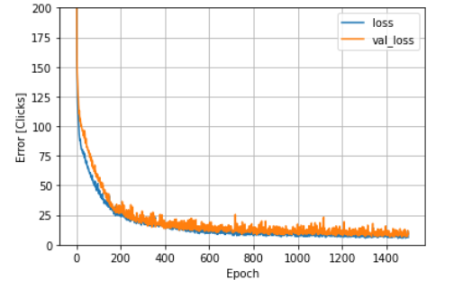

Training Loss: 6.1<br/>
Validation Loss: 9.2<br/>
Mean Squared Error: 115<br/>
Epochs: 1500


### Model one Year for only Time and only Weather

|  Metric         | only Time           |  only Wheather      |
| --------------- | ------------------- | ------------------- |
| Training Loss   | 154                 | 69                  |
| Validation Loss | 186                 | 85                  |
| Epochs          | 1000                | 1000                |


### Model for all Years (2016- 2019)
| Layer       | Number of Neurons | Activation Function |
| ----------- | ----------------- | ------------------- |
| 1           | 256               | ReLu                |
| 2           | 1                 | Linear              |

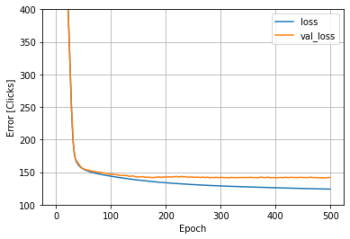

### Model one Year for only Time and only Weather

#### Weather
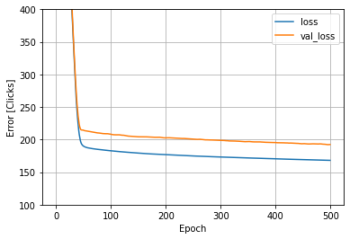

#### Time
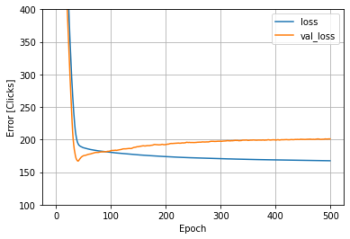

#### Comparisson
|  Metric         | only Time           |  only Wheather      |  with all data      |
| --------------- | ------------------- | ------------------- | ------------------- |
| Training Loss   | 160                 | 161                 | 121                 |
| Validation Loss | 200                 | 190                 | 142                 |
| Epochs          | 1000                | 1000                | 1000                |